<span style="color:SteelBlue; font-size:42px;">Image classification with CNNs</span> 
<hr>
*v1.1 Last updated April 4, 2018*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-to-our-first-task:-'Dogs-vs-Cats'" data-toc-modified-id="Introduction-to-our-first-task:-'Dogs-vs-Cats'-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to our first task: 'Dogs vs Cats'</a></span><ul class="toc-item"><li><span><a href="#Data-download" data-toc-modified-id="Data-download-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data download</a></span></li></ul></li><li><span><a href="#First-look-at-cat-pictures" data-toc-modified-id="First-look-at-cat-pictures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>First look at cat pictures</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Analyzing-results:-looking-at-pictures" data-toc-modified-id="Analyzing-results:-looking-at-pictures-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyzing results: looking at pictures</a></span><ul class="toc-item"><li><span><a href="#A-few-correct-labels-at-random" data-toc-modified-id="A-few-correct-labels-at-random-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>A few correct labels at random</a></span></li><li><span><a href="#A-few-incorrect-labels-at-random" data-toc-modified-id="A-few-incorrect-labels-at-random-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>A few incorrect labels at random</a></span></li><li><span><a href="#The-most-correct-labels-of-each-class" data-toc-modified-id="The-most-correct-labels-of-each-class-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>The most correct labels of each class</a></span></li><li><span><a href="#The-most-incorrect-labels-of-each-class" data-toc-modified-id="The-most-incorrect-labels-of-each-class-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>The most incorrect labels of each class</a></span></li><li><span><a href="#The-most-uncertain-labels" data-toc-modified-id="The-most-uncertain-labels-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>The most uncertain labels</a></span></li></ul></li></ul></div>

# Introduction to our first task: 'Dogs vs Cats'

We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning. 

We're going to try to create a deep learning CNN model for an old Kaggle competion called [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats). There are [25,000 labelled dog and cat photos](https://www.kaggle.com/c/dogs-vs-cats/data) available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): 
>"State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". 

So if we can beat 80%, then we will be at the cutting edge as of 2013!

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need:

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogscats/"

Size set to `224` below because **resnet** uses 224 x 224 image sizes. More on resnet later.

In [5]:
# Size
sz=224

## Data download

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip`. You should put the data in a subdirectory of this notebook's directory, called `data/`.

# First look at cat pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [6]:
# ! means run in bash
# This will show the contents of 'PATH' folder
!ls {PATH}

models	sample	test1  tmp  train  valid


In [7]:
# Show what is in the validation folder
!ls {PATH}valid

cats  dogs


Show what is inside the validation, cats folder. This is standard way to share or provide image classification files!

In [8]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

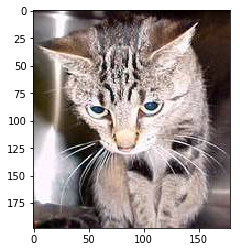

In [9]:
# Example: show first cat image in the cats folder
img = plt.imread(f'{PATH}valid/cats/{files[0]}') # This is formatting string

plt.imshow(img);

Here is how the raw data looks like. This is called a `rank 3 tensor`. Or a simple 3 x 3 matrix.

In [10]:
img.shape

(198, 179, 3)

In [11]:
# Show first four rows and four columns of image. 
# Each cell shows red, green, and blue pixel values btwn 0 and 255.
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

# Model

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

Here's how to train and evalulate a *dogs vs cats* model in 4 lines of code, and under 21 seconds. Under the syntax hood below is code/wrapper written by fast.ai. The fast.ai library is updated regularly and keeps up with deep leaerning research cuttting-edge math and code. So fast.ai makes sure that best practices are always the best! In turn, this works supper fast (e.g., under 21 seconds) because it sits on top of Pytorch, which is a very flexible library written by facebook.

In [1]:
# Uncomment the below if you need to reset your precomputed activations (optional)
# !rm -rf {PATH}tmp

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3) # 1st arg is learning rate; 2nd arg is how many epochs

100%|██████████| 32/32 [00:05<00:00,  6.04it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045726   0.028603   0.989258  
    1      0.039685   0.026488   0.990234                     
    2      0.041631   0.03259    0.990234                     



[0.032590486, 0.990234375]

`resnet34` is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

`data` object contains the training and validation data.

`ImageClassifierData.from_paths` reads in images and their labels given as sub-folder names:
>- `path`: a root path of the data (used for storing trained models, precomputed values, etc)
>- `bs`: batch size. Default 64.
>- `tfms`: transformations (for data augmentations). e.g. output of `tfms_from_model`. Default 'None'
>- `trn_name`: a name of the folder that contains training images. Default 'train'
>- `val_name`: a name of the folder that contains validation images. Default 'valid'
>- `test_name`: a name of the folder that contains test images. Default 'None'
>- `num_workers`: number of workers. Default '8'

`learn` object contains the model.

`ConvLearner.pretrained`:
>- `f`: arch. E.g., resnet34
>- `data`: previously defined data object
>- `precompute`: include/exclude precomputed activations. Default 'False'

Under the syntax hood above is code/wrapper written by fast.ai. The fast.ai library is updated regularly and keeps up with deep leaerning research cuttting-edge math and code. So fast.ai makes sure that best practices are always the best! In turn, this works supper fast (e.g., under 21 seconds) because it sits on top of pytorch, which is a very flexible library written by facebook. Most of the best researchers in the world have switched over to Pytorch!

The `data` object created below contains the training and validation data, read in by `ImageClassifierData.from_paths`.

The `learn` object contains the model.

The `learn.fit` object fits/trains the model through a given learning rate and #epochs. It is going to do three epochs, meaning it is going to look at each image three times in total.

`trn_loss` and `val_loss` are the values of the cross-entropy loss function.

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to **99.0%** accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same fast.ai course, the initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

Above model, can be used on any kind of pictures, as long as it is of things that people normally take photos of. However, things like pathology pictures or CT scans won't do well using this model. There are some other things we need to do to make those work. This will be covered in a subsequent notebook. Stay tuned!

# Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

If we ever want to know about the data we can look inside with a few of the following methods

In [14]:
# This is the label (dependent variable) for a validation data. 
# E.g., output will be either cats = 0, and dogs = 1
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [16]:
# this gives prediction for validation set. Predictions are in log scale.
# Most models return the log of the predictions, rather than the probabilites
# themselves.
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
# Get first 10 predictions
# Column 1 in output below is prediction for dog, and column 2 is prediction for cat
# See how to get actual probs next
log_preds[:10]

array([[-0.00007, -9.57292],
       [-0.00249, -5.99473],
       [-0.00057, -7.46448],
       [-0.00018, -8.61346],
       [-0.00019, -8.58054],
       [-0.00024, -8.34839],
       [-0.00011, -9.10853],
       [-0.00005, -9.92298],
       [-0.00091, -7.00119],
       [-0.00017, -8.65898]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

**Plotting functions**

In [7]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [21]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [22]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

## A few correct labels at random

Correctly classified


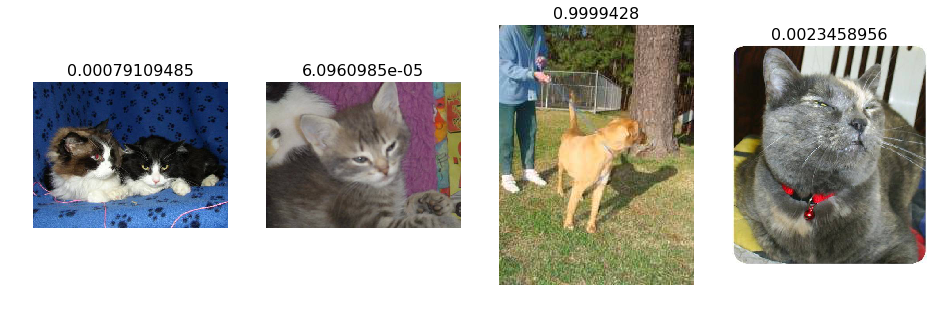

In [23]:
# Anything greater than 0.5 is dog; anything less than 0.5 is cat
plot_val_with_title(rand_by_correct(True), "Correctly classified")

## A few incorrect labels at random

Incorrectly classified


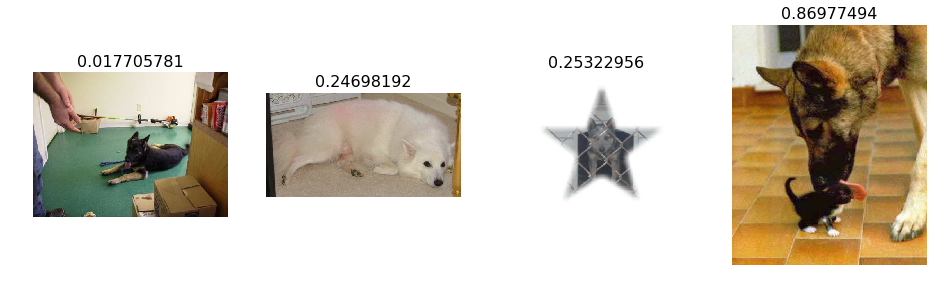

In [24]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [25]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

## The most correct labels of each class 
(i.e., those with highest probability that are correct)

Most correct cats


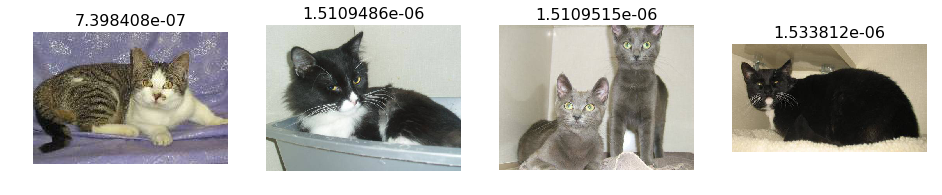

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


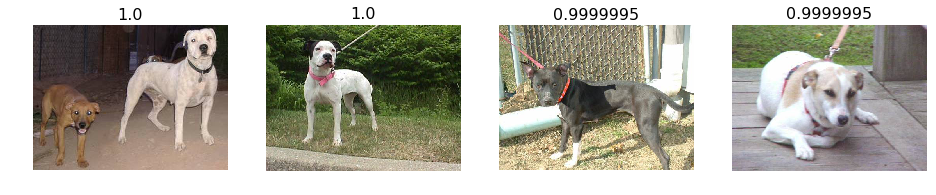

In [27]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

## The most incorrect labels of each class 
(i.e., those with highest probability that are incorrect)

Most incorrect cats


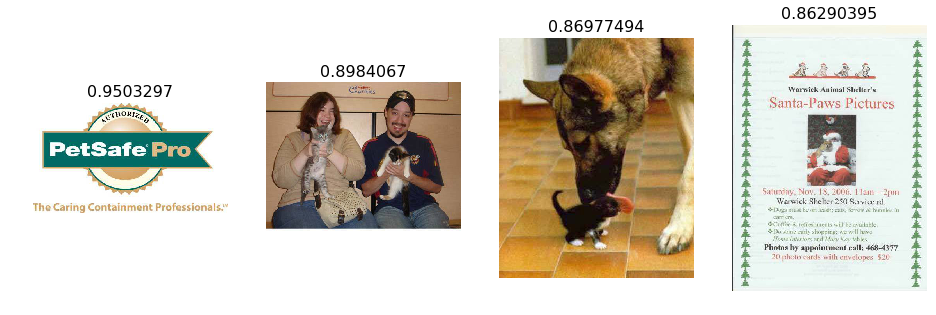

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


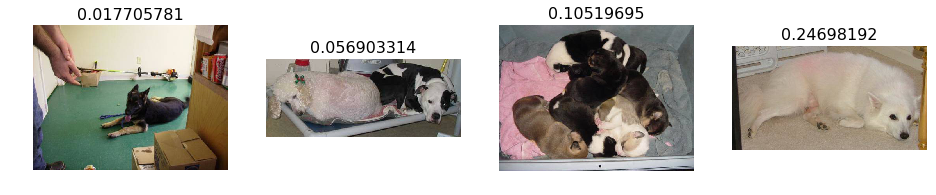

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## The most uncertain labels 
(i.e., those with probability closest to 0.5)

Most uncertain predictions


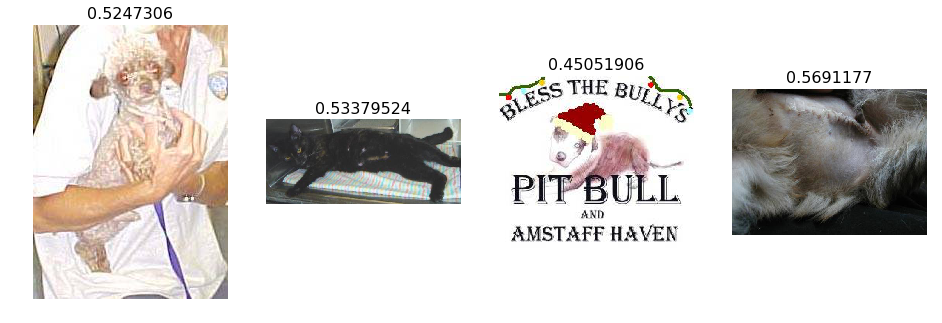

In [30]:
# probabilites are closest to 0.5
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

nb: The images above that are dimensionally wrong, i.e., rectangular, are skewing the results. We take care of this using technique called `data augmentation`. More on that later.

**tip**: 
- if you want to make the model better, you might want to take advantage of why it is doing well and fix the things that it is doing badly. E.g., in another notebook, try removing images that are just skewing the data, like cartoons, etc. If you figure out how to do this, let me know :)